In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
%matplotlib inline

In [51]:
cat_img = io.imread('../input/cat.png')
cat_img.shape

(282, 377, 4)

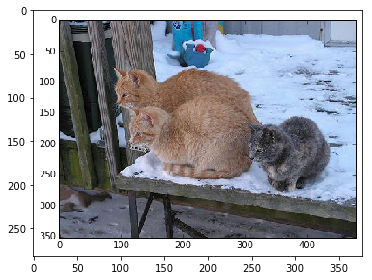

In [3]:
io.imshow(cat_img)

In [4]:
cat_string = cat_img.tostring()
cat_string[0:2]

b'\xff\xff'

In [6]:
# Now let's convert the string back to the image
# Important: the dtype should be specified
# otherwise the reconstruction will be errorness
# Reconstruction is 1d, so we need sizes of image
# to fully reconstruct it.
reconstructed_cat_1d = np.fromstring(cat_string, dtype=np.uint8)

# Here we reshape the 1d representation
# This is the why we need to store the sizes of image
# along with its serialized representation.
reconstructed_cat_img = reconstructed_cat_1d.reshape(cat_img.shape)

reconstructed_cat_1d[0]


255

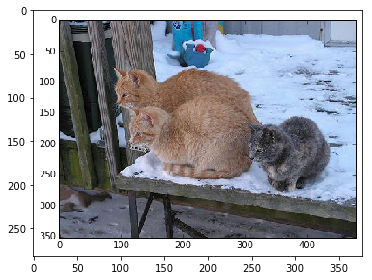

In [11]:
io.imshow(reconstructed_cat_img)

In [36]:
filename_pairs = [
    ('../input/cat.png','../input/cat.png'),
    ('../input/cat.png','../input/cat.png'),
    ('../input/cat.png','../input/cat.png')]

In [37]:
%matplotlib inline

# Important: We are using PIL to read .png files later.
# This was done on purpose to read indexed png files
# in a special way -- only indexes and not map the indexes
# to actual rgb values. This is specific to PASCAL VOC
# dataset data. If you don't want thit type of behaviour
# consider using skimage.io.imread()
from PIL import Image
import numpy as np
import skimage.io as io
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = '../output/pascal_voc_segmentation.tfrecords'

writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, annotation_path in filename_pairs:
    
    img = np.array(Image.open(img_path))
    annotation = np.array(Image.open(annotation_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, annotation))
    
    img_raw = img.tostring()
    annotation_raw = annotation.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'mask_raw': _bytes_feature(annotation_raw)}))
    
    writer.write(example.SerializeToString())

writer.close()

In [38]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    annotation_string = (example.features.feature['mask_raw']
                                .bytes_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    annotation_1d = np.fromstring(annotation_string, dtype=np.uint8)
    
    # Annotations don't have depth (3rd dimension)
    reconstructed_annotation = annotation_1d.reshape((height, width, 4))
    
    reconstructed_images.append((reconstructed_img, reconstructed_annotation))
    
# Let's check if the reconstructed images match
# the original images

for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))

True
True
True
True
True
True


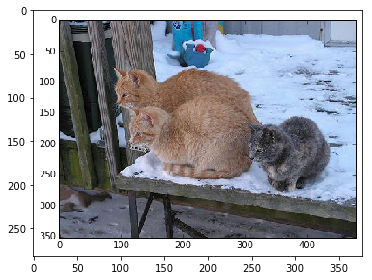

In [39]:
io.imshow(reconstructed_images[0][1])

In [60]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_HEIGHT = 282
IMAGE_WIDTH = 377

def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'mask_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    annotation = tf.decode_raw(features['mask_raw'], tf.uint8)
    
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    
    image_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 4])
    annotation_shape = tf.stack([IMAGE_HEIGHT, IMAGE_WIDTH, 4])
    
    image = tf.reshape(image, image_shape)
    annotation = tf.reshape(annotation, annotation_shape)
    
#     image_size_const = tf.constant((height, width, 3), dtype=tf.int32)
#     annotation_size_const = tf.constant((height, width, 1), dtype=tf.int32)
    
    # Random transformations can be put here: right before you crop images
    # to predefined size. To get more information look at the stackoverflow
    # question linked above.
    
#     resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)
    
#     resized_annotation = tf.image.resize_image_with_crop_or_pad(image=annotation,
#                                            target_height=IMAGE_HEIGHT,
#                                            target_width=IMAGE_WIDTH)
    
    
    images, annotations = tf.train.shuffle_batch( [image, annotation],
                                                 batch_size=1,
                                                 capacity=2,
                                                 num_threads=1,
                                                 min_after_dequeue=1)
    
    return images, annotations

In [61]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=1)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session()  as sess:
    
    sess.run(init_op)
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(1):
    
        img, anno = sess.run([image, annotation])
        print(img[0, :, :, :].shape)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

        io.imshow(img[0, :, :, :])
        io.show()

#         io.imshow(anno[0, :, :, 0])
#         io.show()
        
#         io.imshow(img[1, :, :, :])
#         io.show()

#         io.imshow(anno[1, :, :, 0])
#         io.show()
        
    
    coord.request_stop()
    coord.join(threads)


INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.NotFoundError'>, pascal_voc_segmentation.tfrecords
	 [[Node: ReaderReadV2_1 = ReaderReadV2[_device="/job:localhost/replica:0/task:0/cpu:0"](TFRecordReaderV2_1, input_producer_1)]]


OutOfRangeError: RandomShuffleQueue '_215_shuffle_batch_17/random_shuffle_queue' is closed and has insufficient elements (requested 1, current size 0)
	 [[Node: shuffle_batch_17 = QueueDequeueManyV2[component_types=[DT_UINT8, DT_UINT8], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_17/random_shuffle_queue, shuffle_batch_17/n)]]

Caused by op 'shuffle_batch_17', defined at:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-61-b9b6d10e1a02>", line 6, in <module>
    image, annotation = read_and_decode(filename_queue)
  File "<ipython-input-60-3020442b00fe>", line 60, in read_and_decode
    min_after_dequeue=1)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/input.py", line 1220, in shuffle_batch
    name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/training/input.py", line 791, in _shuffle_batch
    dequeued = queue.dequeue_many(batch_size, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/data_flow_ops.py", line 457, in dequeue_many
    self._queue_ref, n=n, component_types=self._dtypes, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gen_data_flow_ops.py", line 1342, in _queue_dequeue_many_v2
    timeout_ms=timeout_ms, name=name)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): RandomShuffleQueue '_215_shuffle_batch_17/random_shuffle_queue' is closed and has insufficient elements (requested 1, current size 0)
	 [[Node: shuffle_batch_17 = QueueDequeueManyV2[component_types=[DT_UINT8, DT_UINT8], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](shuffle_batch_17/random_shuffle_queue, shuffle_batch_17/n)]]
